In [2]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from prop_models import coro, agpm
reload(coro)

from wfsc import efc_1dm as efc
from wfsc import utils

import misc
wavelength_c = 750e-9*u.m

ImportError: cannot import name 'misc' from 'prop_models' (unknown location)

In [8]:
from misc_funcs import misc

misc.myimshow

<function misc_funcs.misc.myimshow(arr, title=None, npix=None, lognorm=False, vmin=None, vmax=None, cmap='magma', pxscl=None, patches=None, grid=False, figsize=(4, 4), dpi=125, display_fig=True, return_fig=False)>

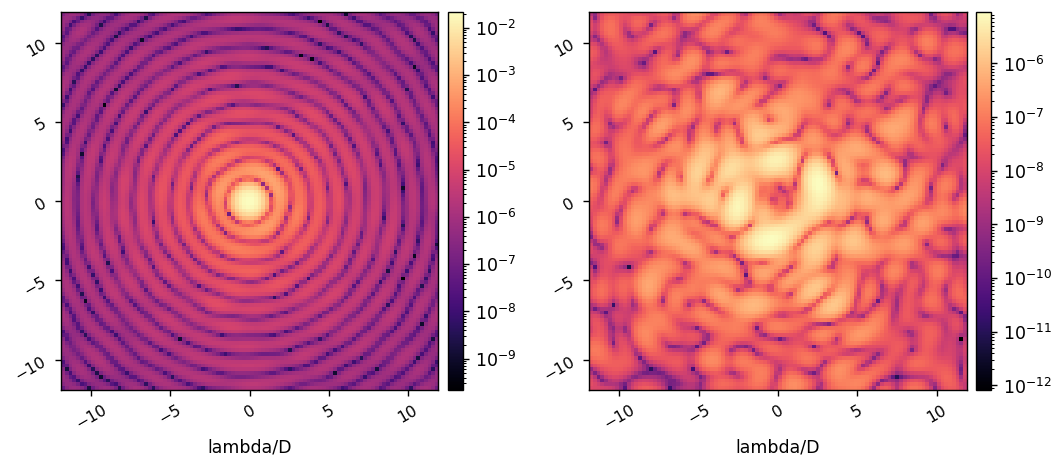

In [23]:
reload(coro)

vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=3*u.mm, gray_pixel=False)

c = coro.CORO(dm_inf='inf.fits',
              npix=128,
              oversample=16,
              npsf=100,
              use_opds=True,
              LYOT=lyot_stop
             )
c.FPM = poppy.ScalarTransmission()
im_unocc = c.snap()

c.FPM = vortex
ref_im = c.snap()

misc.myimshow2(im_unocc, ref_im, 
               lognorm1=True, lognorm2=True,
               pxscl1=c.psf_pixelscale_lamD, pxscl2=c.psf_pixelscale_lamD)

In [27]:
c.Nact

34

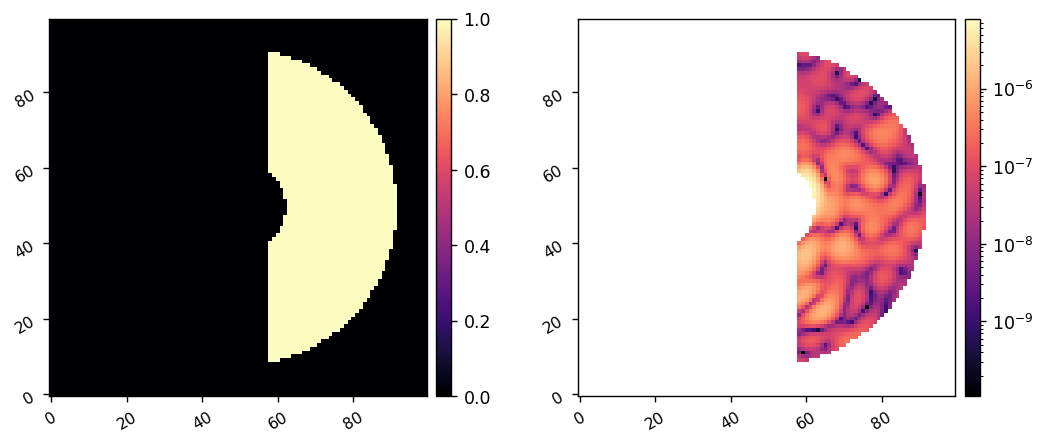

In [35]:
reload(utils)
npsf = c.npsf
nact = c.Nact

xfp = (np.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*c.psf_pixelscale_lamD
fpx,fpy = np.meshgrid(xfp,xfp)

edge = 2
iwa = 3
owa = 10
rot = 0

# Create the mask that is used to select which region to make dark.
dark_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
    'direction' : '+x',
    'rotation':rot,
    'full': False
}
dark_mask = utils.create_annular_focal_plane_mask(fpx, fpy, dark_params)
misc.myimshow2(dark_mask, dark_mask*ref_im,
               lognorm2=True)

In [36]:
reload(efc)

epsilon = 1e-9 # poke amplitudes (DM surface)
jac = efc.build_jacobian(c, epsilon, dark_mask.flatten(), display=False)

Building Jacobian.


AttributeError: 'CORO' object has no attribute 'add_dm1'